# Tutorial 4: Initializing a small-scale chain

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from gstatsMCMC import Topography
from gstatsMCMC import MCMC
import gstatsim as gs
from sklearn.preprocessing import QuantileTransformer
import skgstat as skg

In [2]:
# load compiled bed elevation measurements
df = pd.read_csv('ScottDataGriddedFinal.csv')

In [3]:
# create a grid of x and y coordinates
x_uniq = np.unique(df.x)
y_uniq = np.unique(df.y)

xmin = np.min(x_uniq)
xmax = np.max(x_uniq)
ymin = np.min(y_uniq)
ymax = np.max(y_uniq)

cols = len(x_uniq)
rows = len(y_uniq)

resolution = 500

xx, yy = np.meshgrid(x_uniq, y_uniq)

In [4]:
# load other data
dhdt = df['dhdt'].values.reshape(xx.shape)
smb = df['smb'].values.reshape(xx.shape)
velx = df['velx'].values.reshape(xx.shape)
vely = df['vely'].values.reshape(xx.shape)
bedmap_mask = df['bedmap_mask'].values.reshape(xx.shape)
bedmachine_thickness = df['bedmachine_thickness'].values.reshape(xx.shape)
bedmap_surf = df['bedmap_surf'].values.reshape(xx.shape)
highvel_mask = df['highvel_mask'].values.reshape(xx.shape)
bedmachine_bed = df['bedmap_surf'].values.reshape(xx.shape) - bedmachine_thickness
bedmap_bed = df['bedmap_bed'].values.reshape(xx.shape)

In [5]:
# create conditioning data
# bed elevation measurement in grounded ice region, and bedmachine bed topography elsewhere
cond_bed = np.where(bedmap_mask == 1, df['bed'].values.reshape(xx.shape), bedmap_bed)
df['cond_bed'] = cond_bed.flatten()
# create a mask of conditioning data
data_mask = ~np.isnan(cond_bed)

#### Calculate the trend

In [6]:
initial_bed = np.loadtxt('largescalebedtxt.txt')

In [7]:
import scipy as sp
trend = sp.ndimage.gaussian_filter(initial_bed, sigma=10)

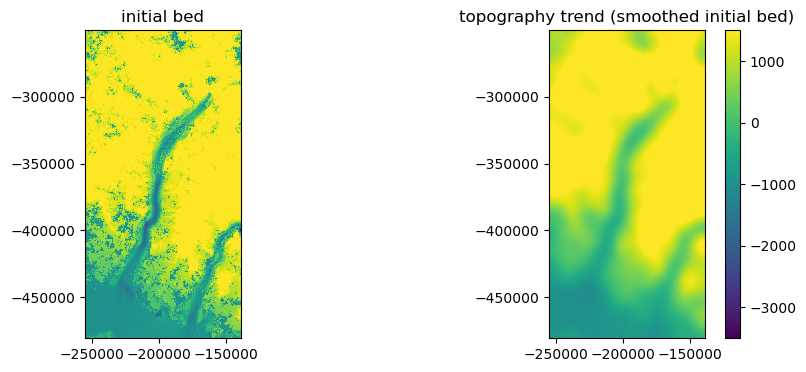

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4),gridspec_kw={'width_ratios': [1, 1.3]} )

axes[0].pcolormesh(xx, yy, initial_bed, vmax=1500,vmin=-3500)
axes[0].set_title('initial bed')
axes[0].set_aspect('equal')

bedfig = axes[1].pcolormesh(xx, yy, trend, vmax=1500,vmin=-3500)
axes[1].set_title('topography trend (smoothed initial bed)')
axes[1].set_aspect('equal')
fig.colorbar(bedfig, ax=axes[1])

#### Calculate detrended variogram

In [9]:
###################WHEN NO DETREND###################
# normalize the conditioning bed data, saved to df['Nbed']
data = df['cond_bed'].values.reshape(-1,1)
nst_trans = QuantileTransformer(n_quantiles=500, output_distribution="normal",random_state=0).fit(data)
transformed_data = nst_trans.transform(data)
df['Nbed'] = transformed_data

In [10]:
###################WHEN DETRENDING###################
'''
# normalize the de-trended conditioning data, saved to df['Nbed_residual']
df['cond_bed_residual']=df['cond_bed'].values-trend.flatten()
data = df['cond_bed_residual'].values.reshape(-1,1)
nst_trans = QuantileTransformer(n_quantiles=500, output_distribution="normal",random_state=0).fit(data)
transformed_data = nst_trans.transform(data)
df['Nbed_residual'] = transformed_data
'''

'\n# normalize the de-trended conditioning data, saved to df[\'Nbed_residual\']\ndf[\'cond_bed_residual\']=df[\'cond_bed\'].values-trend.flatten()\ndata = df[\'cond_bed_residual\'].values.reshape(-1,1)\nnst_trans = QuantileTransformer(n_quantiles=500, output_distribution="normal",random_state=0).fit(data)\ntransformed_data = nst_trans.transform(data)\ndf[\'Nbed_residual\'] = transformed_data\n'

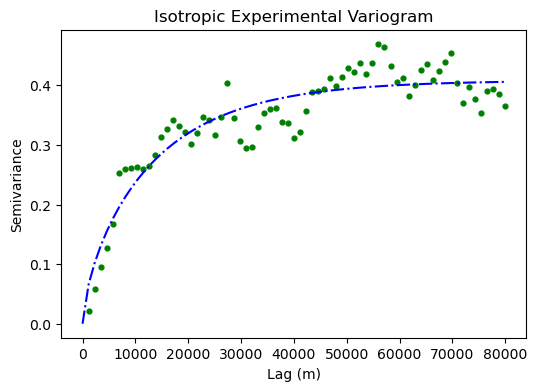

In [11]:
###################WHEN DETRENDING###################
'''
# randomly drop out 50% of coordinates. Decrease this value if you have a lot of data and it takes a long time to run
df_sampled = df.sample(frac=0.4, random_state=42)
df_sampled = df_sampled[df_sampled["cond_bed_residual"].isnull() == False]
df_sampled = df_sampled[df_sampled["bedmap_mask"]==1]

# compute experimental (isotropic) variogram
coords = df_sampled[['x','y']].values
values = df_sampled['Nbed_residual']
'''

###################WHEN NO DETREND###################
df_sampled = df.sample(frac=0.4, random_state=42)
df_sampled = df_sampled[df_sampled["cond_bed"].isnull() == False]
df_sampled = df_sampled[df_sampled["bedmap_mask"]==1]
coords = df_sampled[['x','y']].values
values = df_sampled['Nbed']

maxlag = 80000      # maximum range distance
n_lags = 70         # num of bins (try decreasing if this is taking too long)

# compute variogram
V1 = skg.Variogram(coords, values, bin_func='even', n_lags=n_lags, maxlag=maxlag, normalize=False, model='matern')

# extract variogram values
xdata = V1.bins
ydata = V1.experimental

V1_p = V1.parameters

# evaluate models
xi = np.linspace(0, xdata[-1], n_lags) 
y_mtn = [skg.models.matern(h, V1_p[0], V1_p[1], V1_p[2], V1_p[3]) for h in xi]
# variogram parameter is [range, sill, shape, nugget] for matern model.

plt.figure(figsize=(6,4))
plt.scatter(xdata, ydata, s=12, c='g')
plt.plot(xi, y_mtn,'b-.', label='Matern variogram model')
plt.title('Isotropic Experimental Variogram')
plt.xlabel('Lag (m)'); plt.ylabel('Semivariance')
plt.show()


In [12]:
V1_p

[40060.09959823356, 0.40824452723256166, 0.32363571716300815, 0]

In [13]:
###################WHEN NO DETREND###################
# load the initial bed, make sure no bed in grounded ice region is higher altitude than ice surface
startbed = np.loadtxt('largescalebedtxt.txt')
thickness = bedmap_surf - startbed
startbed = np.where((thickness<=0)&(bedmap_mask==1), bedmap_surf-1, startbed)

### Then initiating the SGS chain

The first 4 initialization process are very similar to chain_crf, please refers to Tutorial 3 for detailed information

In [14]:
grounded_ice_mask = (bedmap_mask == 1)

In [15]:
###################WHEN NO DETREND###################
smallScaleChain = MCMC.chain_sgs(xx, yy, startbed, bedmap_surf, velx, vely, dhdt, smb, cond_bed, data_mask, grounded_ice_mask, resolution)

before running the chain, please set where the block update will be using the object's function set_update_in_region(region_mask) and set_update_region(update_in_region)
please also set up the sgs parameters using set_sgs_param(self, block_size, sgs_param)
then please set up the loss function using either set_loss_type or set_loss_func


In [16]:
###################WHEN DETRENDING###################
# smallScaleChain = MCMC.chain_sgs(xx, yy, initial_bed, bedmap_surf, velx, vely, dhdt, smb, cond_bed, data_mask, grounded_ice_mask, resolution)

In [17]:
smallScaleChain.set_update_region(True,highvel_mask)

the update blocks is set to be randomly generated for any locations inside the given region


In [18]:
smallScaleChain.set_loss_type(map_func='sumsquare', sigma_mc=5, massConvInRegion=True)

In [19]:
# set up the block sizes
min_block_x = 5
max_block_x = 20
min_block_y = 5
max_block_y = 20
smallScaleChain.set_block_sizes(min_block_x, max_block_x, min_block_y, max_block_y)

Sequential Gaussian Simulation is set to perform on the normalized data. This nst_trans is an object of the QuantileTranformer class in scikit-learn python library. The *fit_variogram* function returns a nst_trans object, which could be directly used here

In [20]:
smallScaleChain.set_normal_transformation(nst_trans, do_transform=False)

In [21]:
###################WHEN DETRENDING###################
# smallScaleChain.set_normal_transformation(nst_trans, do_transform=True)

When running the SGS chain, it is possible to 'detrend' the topography.

Detrend topography refers to substracting a pre-defined trend from the topography map, where the trend suppose to represent long-wavelength features that violate stationary properties of SGS. If choose to detrend the topography, the argument *detrend_map* need to be set to True, and the argument *trend* need to be a 2D numpy array representing the topography trend

In [22]:
smallScaleChain.set_trend(trend = [], detrend_map = False)

In [23]:
###################WHEN DETRENDING###################
# smallScaleChain.set_trend(trend = trend, detrend_map = True)

In [24]:
smallScaleChain.set_variogram('Matern',V1_p[0],V1_p[1],0,isotropic=True,vario_smoothness=V1_p[2])

the variogram is set to type Matern


In [25]:
smallScaleChain.set_sgs_param(48, 50e3, sgs_rand_dropout_on=False)

because the sgs_rand_dropout_on is set to False, the dropout_rate is automatically set to 0


The small scale chain should run until the loss graph plateaus or is lower than BedMachine (see end of T3). For most purposes, the number of iterations should be much larger than what is currently being done (5000) and the possibility that it still does not reach BedMachine is possible.

In [26]:
iterations = 5000

In [27]:
seed = 23034902
randomGenerator = np.random.default_rng(seed)

beds, loss_mc, loss_data, loss, steps, resampled_times, blocks_used = smallScaleChain.run_newsgs(n_iter=iterations, rng_seed=randomGenerator, only_save_last_bed=False, info_per_iter = 200)

i: 0 mc loss: 2.800e+05 loss: 2.800e+05 acceptance rate: 1.0
i: 200 mc loss: 1.771e+05 loss: 1.771e+05 acceptance rate: 0.2885572139303483
i: 400 mc loss: 1.142e+05 loss: 1.142e+05 acceptance rate: 0.3092269326683292
i: 600 mc loss: 9.678e+04 loss: 9.678e+04 acceptance rate: 0.3211314475873544
i: 800 mc loss: 8.731e+04 loss: 8.731e+04 acceptance rate: 0.3146067415730337
i: 1000 mc loss: 8.084e+04 loss: 8.084e+04 acceptance rate: 0.33966033966033965
i: 1200 mc loss: 7.491e+04 loss: 7.491e+04 acceptance rate: 0.3430474604496253
i: 1400 mc loss: 7.207e+04 loss: 7.207e+04 acceptance rate: 0.3461812990720914
i: 1600 mc loss: 6.055e+04 loss: 6.055e+04 acceptance rate: 0.34603372891942535
i: 1800 mc loss: 5.857e+04 loss: 5.857e+04 acceptance rate: 0.3375902276513048
i: 2000 mc loss: 5.582e+04 loss: 5.582e+04 acceptance rate: 0.33233383308345826
i: 2200 mc loss: 5.425e+04 loss: 5.425e+04 acceptance rate: 0.328032712403453
i: 2400 mc loss: 5.227e+04 loss: 5.227e+04 acceptance rate: 0.3223656809

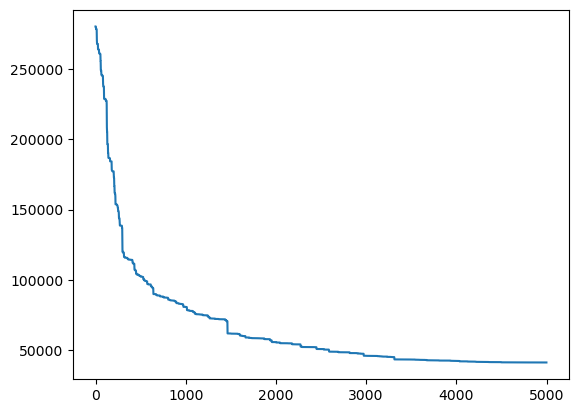

In [28]:
plt.plot(loss)

(-255500.0, -139000.0, -480500.0, -250500.0)

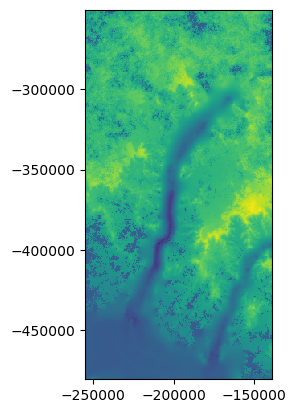

In [29]:
plt.pcolormesh(xx, yy, beds[-1], vmax = 4000, vmin = -3000)
plt.axis('scaled')

In [32]:
np.savetxt('SmallScaleBed0txt.txt', beds[-1])
np.savetxt('SmallScaleLoss0txt.txt', loss)

In [30]:
beds0 = np.loadtxt('SmallScaleBed0txt.txt')
loss0 = np.loadtxt('SmallScaleLoss0txt.txt')
loss_bedmachine = np.loadtxt('lossbedmachine')

In [31]:
beds.shape

(5000, 460, 233)

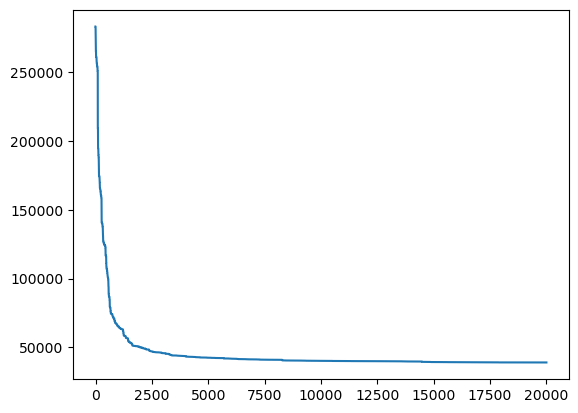

In [32]:
plt.plot(loss0)

In [34]:
sgs_bed = np.loadtxt('sgs_bed.txt')
thickness = bedmap_surf - sgs_bed
sgs_bed = np.where((thickness<=0)&(bedmap_mask==1), bedmap_surf-1, sgs_bed)

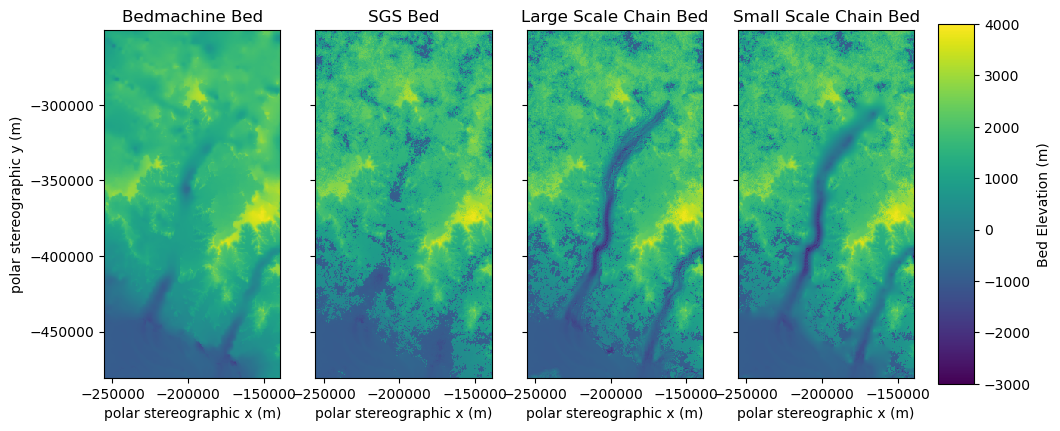

In [38]:
fig, axes = plt.subplots(1, 4, figsize=(12, 24))

im = ax.imshow(bedmachine_bed, vmax = 4000, vmin = -3000)

axes[0].pcolormesh(xx,yy, bedmachine_bed, vmax = 4000, vmin = -3000)
axes[0].set_title('Bedmachine Bed')
axes[0].set_aspect('equal')

axes[1].pcolormesh(xx,yy, sgs_bed, vmax = 4000, vmin = -3000)
axes[1].set_title('SGS Bed')
axes[1].set_aspect('equal')

axes[2].pcolormesh(xx,yy, startbed , vmax = 4000 , vmin = -3000)
axes[2].set_title('Large Scale Chain Bed')
axes[2].set_aspect('equal')

axes[3].pcolormesh(xx,yy, beds0 , vmax = 4000 , vmin = -3000)
axes[3].set_title('Small Scale Chain Bed')
axes[3].set_aspect('equal')

for ax in axes.flat:
    ax.set(xlabel='polar stereographic x (m)', ylabel='polar stereographic y (m)')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axes.flat:
    ax.label_outer()

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.42, 0.03, 0.15])
fig.colorbar(im, cax=cbar_ax, label = 'Bed Elevation (m)')


fig.savefig('BedCompilation')

Text(0, 0.5, 'y (m)')

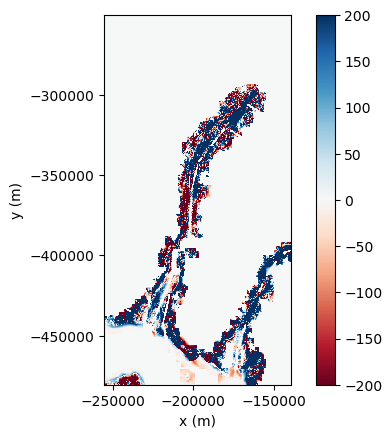

In [39]:
plt.pcolormesh(xx,yy,beds[-1]-beds[0], cmap='RdBu',vmax=200,vmin=-200)
plt.axis('scaled')
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('y (m)')

Text(0, 0.5, 'y (m)')

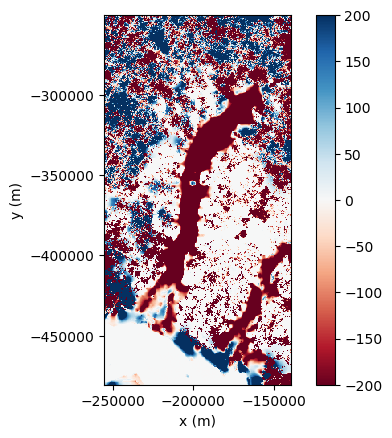

In [40]:
plt.pcolormesh(xx,yy,beds0 - bedmachine_bed, cmap='RdBu',vmax=200,vmin=-200)
plt.axis('scaled')
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('y (m)')

The following cells compare variograms of various bed measurments. If you wish to change these, make sure the first df['___'], middle df_sampled, and values variables are all the same. Other than that, avoid changing other variables such as the maxlag or n_lags unless all are changed at once to recieve a good comparison.

In [41]:
# randomly drop out 60% of coordinates. Decrease this value if you have a lot of data and it takes a long time to run
df_sampled = df.sample(frac=0.4, random_state=42)
df_sampled = df_sampled[df_sampled["cond_bed"].isnull() == False]
df_sampled = df_sampled[df_sampled["bedmap_mask"] == 1]

# compute experimental (isotropic) variogram
coords = df_sampled[['x','y']].values
values = df_sampled['cond_bed']

maxlag = 80000      # maximum range distance
n_lags = 60         # num of bins (try decreasing if this is taking too long)

# compute variogram
V1 = skg.Variogram(coords, values, bin_func='even', n_lags=n_lags, maxlag=maxlag, normalize=False, model='matern', samples = 0.4)

# extract variogram values
xdata_cond = V1.bins
ydata_cond = V1.experimental

V1_p = V1.parameters

In [42]:
df['bedmachine_bed'] = bedmachine_bed.flatten()

# randomly drop out 60% of coordinates. Decrease this value if you have a lot of data and it takes a long time to run
df_sampled = df.sample(frac=0.4, random_state=42)
df_sampled = df_sampled[df_sampled["bedmachine_bed"].isnull() == False]
df_sampled = df_sampled[df_sampled["bedmap_mask"] == 1]

# compute experimental (isotropic) variogram
coords = df_sampled[['x','y']].values
values = df_sampled['bedmachine_bed']

maxlag = 80000      # maximum range distance
n_lags = 60         # num of bins (try decreasing if this is taking too long)

# compute variogram
V2 = skg.Variogram(coords, values, bin_func='even', n_lags=n_lags, maxlag=maxlag, normalize=False, model='matern', samples = 0.4)

# extract variogram values
xdata_bedmachine = V2.bins
ydata_bedmachine = V2.experimental

V2_p = V2.parameters

In [43]:
df['sgs_bed'] = sgs_bed.flatten()

# randomly drop out 50% of coordinates. Decrease this value if you have a lot of data and it takes a long time to run
df_sampled = df.sample(frac=0.4, random_state=42)
df_sampled = df_sampled[df_sampled["sgs_bed"].isnull() == False]
df_sampled = df_sampled[df_sampled["bedmap_mask"]==1]

# compute experimental (isotropic) variogram
coords = df_sampled[['x','y']].values
values = df_sampled['sgs_bed']

maxlag = 80000      # maximum range distance
n_lags = 60         # num of bins (try decreasing if this is taking too long)

# compute variogram
V3 = skg.Variogram(coords, values, bin_func='even', 
                   n_lags=n_lags, maxlag=maxlag, normalize=False, 
                   model='matern', samples = 0.4)

# extract variogram values
xdata_sgs = V3.bins
ydata_sgs = V3.experimental
V3_p = V3.parameters

In [44]:
df['large_scale_topography'] = startbed.flatten()

# randomly drop out 50% of coordinates. Decrease this value if you have a lot of data and it takes a long time to run
df_sampled = df.sample(frac=0.4, random_state=42)
df_sampled = df_sampled[df_sampled["large_scale_topography"].isnull() == False]
df_sampled = df_sampled[df_sampled["bedmap_mask"]==1]

# compute experimental (isotropic) variogram
coords = df_sampled[['x','y']].values
values = df_sampled['large_scale_topography']

maxlag = 80000      # maximum range distance
n_lags = 60         # num of bins (try decreasing if this is taking too long)

# compute variogram
V4 = skg.Variogram(coords, values, bin_func='even', 
                   n_lags=n_lags, maxlag=maxlag, normalize=False, 
                   model='matern', samples = 0.4)

# extract variogram values
xdata_LSC = V4.bins
ydata_LSC = V4.experimental
V4_p = V4.parameters

In [45]:
df['small_scale_topography'] = beds0.flatten()

# randomly drop out 60% of coordinates. Decrease this value if you have a lot of data and it takes a long time to run
df_sampled = df.sample(frac=0.4, random_state=42)
df_sampled = df_sampled[df_sampled["small_scale_topography"].isnull() == False]
df_sampled = df_sampled[df_sampled["bedmap_mask"] == 1]

# compute experimental (isotropic) variogram
coords = df_sampled[['x','y']].values
values = df_sampled['small_scale_topography']

maxlag = 80000      # maximum range distance
n_lags = 60         # num of bins (try decreasing if this is taking too long)

# compute variogram
V5 = skg.Variogram(coords, values, bin_func='even', n_lags=n_lags, maxlag=maxlag, normalize=False, model='matern', samples = 0.4)

# extract variogram values
xdata_SSC = V5.bins
ydata_SSC = V5.experimental

V5_p = V5.parameters

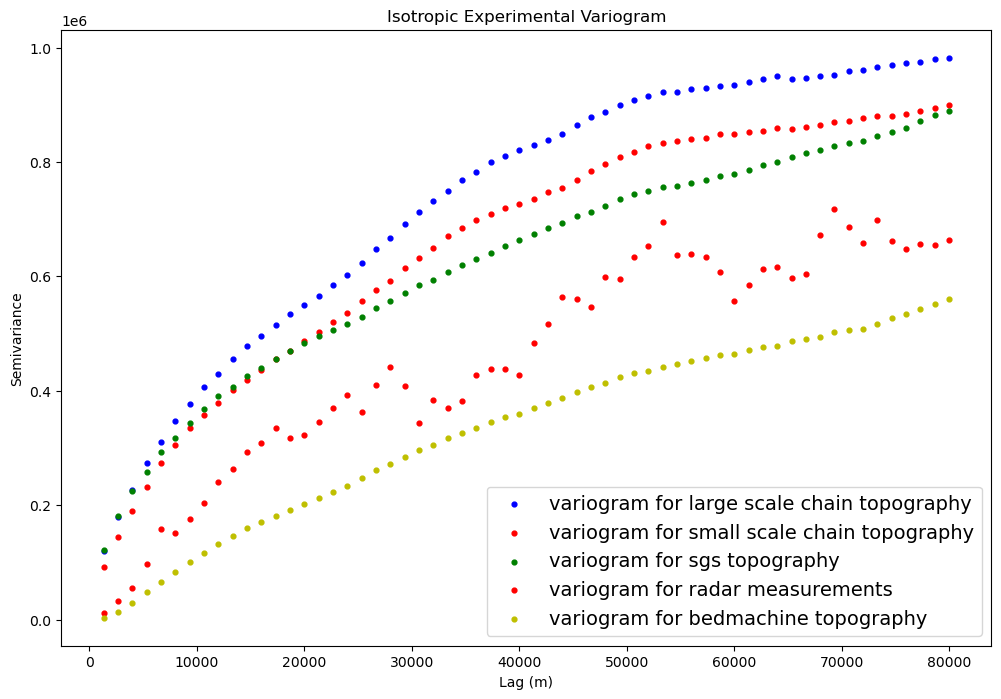

In [46]:
# compare experimental variogram
plt.figure(figsize=(12,8))
plt.scatter(xdata_LSC, ydata_LSC, s=12, c='b', label='variogram for large scale chain topography')
plt.scatter(xdata_SSC, ydata_SSC, s=12, c='r', label='variogram for small scale chain topography')
plt.scatter(xdata_sgs, ydata_sgs, s=12, c='g', label='variogram for sgs topography')
plt.scatter(xdata_cond, ydata_cond, s=12, c='r', label='variogram for radar measurements')
plt.scatter(xdata_bedmachine, ydata_bedmachine, s=12, c='y', label='variogram for bedmachine topography')
plt.title('Isotropic Experimental Variogram')
plt.xlabel('Lag (m)'); plt.ylabel('Semivariance')
plt.legend(loc='lower right', fontsize=14)

plt.savefig('BigVariogram.png')

The following section is heavily simplified and is used to make small scale realizations of large scale realizations that are not the final iteration. Such as those ten or twenty thousand prior to the final iteration for comparison. The following cells should then be run as many times as needed, changing the first np.loadtxt to be the right file and change the final np.savetxts to be distinct files.

In [68]:
# This section is manually rerun by changing the np.loadtxt file to match the desired large scale chain iteration to begin the small scale chain
LCSbed = np.loadtxt('BedAt_35_x_25000_iterations.txt')
thickness = bedmap_surf - LCSbed
LCSbed = np.where((thickness<=0)&(bedmap_mask==1), bedmap_surf-1, LCSbed)

# The following assumes no detrending is being done
smallScaleChain = MCMC.chain_sgs(xx, yy, LCSbed, bedmap_surf, velx, vely, dhdt, smb, cond_bed, data_mask, grounded_ice_mask, resolution)
smallScaleChain.set_update_region(True,highvel_mask)
smallScaleChain.set_loss_type(map_func='sumsquare', sigma_mc=5, massConvInRegion=True)
smallScaleChain.set_block_sizes(min_block_x, max_block_x, min_block_y, max_block_y)
smallScaleChain.set_normal_transformation(nst_trans, do_transform=False)
smallScaleChain.set_variogram('Matern',V1_p[0],V1_p[1],0,isotropic=True,vario_smoothness=V1_p[2])
smallScaleChain.set_trend(trend = [], detrend_map = False)
smallScaleChain.set_sgs_param(48, 50e3, sgs_rand_dropout_on=False)

# Number of iterations is controlled by first variable
beds, loss_mc, loss_data, loss, steps, resampled_times, blocks_used = smallScaleChain.run_newsgs(n_iter=iterations, rng_seed=randomGenerator, only_save_last_bed=False, info_per_iter = 200)

before running the chain, please set where the block update will be using the object's function set_update_in_region(region_mask) and set_update_region(update_in_region)
please also set up the sgs parameters using set_sgs_param(self, block_size, sgs_param)
then please set up the loss function using either set_loss_type or set_loss_func
the update blocks is set to be randomly generated for any locations inside the given region
the variogram is set to type Matern
because the sgs_rand_dropout_on is set to False, the dropout_rate is automatically set to 0
i: 0 mc loss: 3.409e+05 loss: 3.409e+05 acceptance rate: 0.0
i: 200 mc loss: 1.992e+05 loss: 1.992e+05 acceptance rate: 0.43283582089552236
i: 400 mc loss: 1.467e+05 loss: 1.467e+05 acceptance rate: 0.41895261845386533
i: 600 mc loss: 1.061e+05 loss: 1.061e+05 acceptance rate: 0.4043261231281198
i: 800 mc loss: 8.195e+04 loss: 8.195e+04 acceptance rate: 0.3995006242197253
i: 1000 mc loss: 6.781e+04 loss: 6.781e+04 acceptance rate: 0.39060

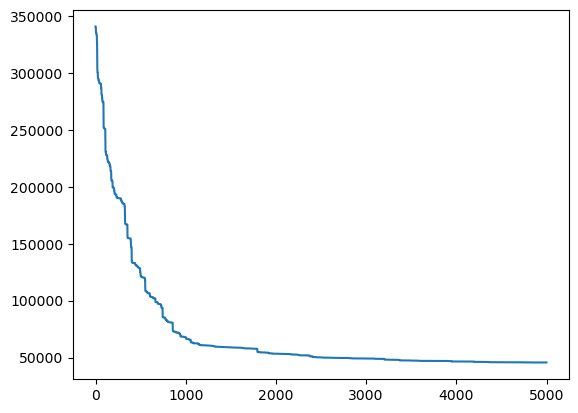

In [69]:
plt.plot(loss)

In [70]:
# Change the file names if used multiple times to avoid replacing files
np.savetxt('SmallScaleBed5txt.txt', beds[-1])
np.savetxt('SmallScaleLoss5txt.txt', loss)

The following cells compile loss information from both MCMC chains and repeated small scale chains to produce a loss graph with multiple final SGS realizations at different points along the large scale chain.

In [48]:
LargeScaleLoss = np.loadtxt('biglosstxt.txt')

loss01 = np.loadtxt('SmallScaleLoss1txt.txt')
loss02 = np.loadtxt('SmallScaleLoss2txt.txt')
loss03 = np.loadtxt('SmallScaleLoss3txt.txt')
loss04 = np.loadtxt('SmallScaleLoss4txt.txt')
loss05 = np.loadtxt('SmallScaleLoss5txt.txt')

# The number in brackets should be which iteration of large scale chain the bed was
LCSgraph01 = np.concatenate((LargeScaleLoss[:975000], loss01))
LCSgraph02 = np.concatenate((LargeScaleLoss[:950000], loss02))
LCSgraph03 = np.concatenate((LargeScaleLoss[:925000], loss03))
LCSgraph04 = np.concatenate((LargeScaleLoss[:900000], loss04))
LCSgraph05 = np.concatenate((LargeScaleLoss[:875000], loss05))

In [49]:
beds0 = np.loadtxt('SmallScaleBed0txt.txt')
loss0 = np.loadtxt('SmallScaleLoss0txt.txt')
loss_bedmachine = np.loadtxt('lossbedmachine')

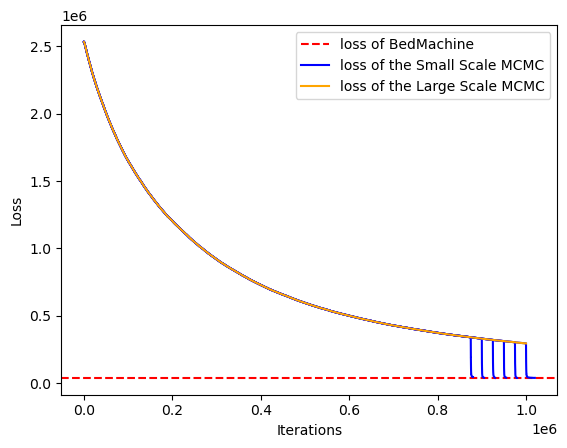

In [50]:
biggraph = np.concatenate((LargeScaleLoss, loss0))

plt.axhline(loss_bedmachine[0],ls='--',c='red',label='loss of BedMachine')

plt.plot(LCSgraph01, c = 'blue')
plt.plot(LCSgraph02, c = 'blue')
plt.plot(LCSgraph03, c = 'blue')
plt.plot(LCSgraph04, c = 'blue')
plt.plot(LCSgraph05, c = 'blue')

plt.plot(biggraph, c = 'blue', label='loss of the Small Scale MCMC')
plt.plot(LargeScaleLoss, c= 'orange', label='loss of the Large Scale MCMC')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()